# Assignment 2 by: Monty Sefer (s3784357)



### Run this first 
### This and 1.1 should allow any task to function independantly

In [1]:
#pandas packages
import pandas as pd 
from pandas.plotting import scatter_matrix

#numpy packages
import numpy as np  

#matplotlib packages
from matplotlib import pyplot as plt 

#sklearn packages
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import preprocessing
from sklearn import cluster
from sklearn.cluster import KMeans 

#statistics packages
from statistics import mean 

#disables annoying warnings
import warnings
warnings.filterwarnings('ignore')

#random num package
import random

#progress bar package
from tqdm import tqdm

#seaborn package for heatmap
import seaborn as sns

# Task 1: Data Preparation and Analysis


## Task 1.1


In [6]:
seed = 12345               #Change for new data subset
bye_outliers = True        #Set to false to leave outliers
threshold = 1.5            #Outlier IQR threshold


data_filename = 'A2data.csv'  #imports data              
data = pd.read_csv(data_filename,  sep=';', decimal='.', header =0)  #sets import parameters


#removing whitespace and missing values (the str cells were really annoying btw)
data=data.mask(data.apply(pd.to_numeric,errors = 'coerce').isnull(),data.astype(str).apply(lambda x : x.str.strip()))  #finds empty string cells that dropna would miss
data.dropna(inplace=True)  #dropping null cells
for i in data.columns:
    empty_rows_to_drop = data[data[i]==''].index   #identifying empty cells
    nan_rows_to_drop = data[data[i]=='nan'].index  #identifying nan strings
    data.drop(empty_rows_to_drop, inplace=True)    #dropping empty cells
    data.drop(nan_rows_to_drop, inplace=True)      #dropping nan strings
data.to_csv('A2dataCleaned.csv')
#for some reason the outlier code wont work unless the data set is saved and reopened, spits out a str - str error
#incase youre curious yes freaking hours of troubleshooting and trial and error lead me to this solution
data_filename = 'A2dataCleaned.csv'
data = data = pd.read_csv(data_filename,  sep=',', decimal='.', header =0)
data.drop(columns=data.columns[0], axis=0,  inplace=True)  #removing identifier column

#finding outliers using IQR method
def outlier(dataframe, column): 
    Q1 = dataframe[column].quantile(.25)  #quartile 1
    Q3 = dataframe[column].quantile(.75)  #quartile 4
    IQR = Q3-Q1  #Inter Quartile Range
    
    lower_bound = Q1 - threshold * IQR  
    upper_bound = Q3 + threshold * IQR  
    gremlins = dataframe.index[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]  #identifies outliers
    return gremlins  #returns outliers
index_list = []  #for assigning outliers
for i in data.iloc[:, :11].columns:  #outlier function is called for every column but quality
    index_list.extend(outlier(data, i))

#removing outliers
def remove_outlier(dataframe, gremlins):  #function to drop outliers
    gremlins = sorted(set(gremlins))
    dataframe = dataframe.drop(gremlins)
    return dataframe

if bye_outliers == True:  #removes outliers via function if parameter is set to true (top of page)
    data_cleaned = remove_outlier(data, index_list)
print(len(index_list), 'outliers identified')

#random data sampling
subset = data_cleaned.sample(n=600, random_state = seed) #creates a subset of 600 random values in the data set
subset.to_csv('A2RandomSample.csv')  #writes subset to csv file
wine_filename = 'A2RandomSample.csv'  #imports subset data as new dataframe             
wine = pd.read_csv(wine_filename,  sep=',', decimal='.', header =0)  #sets import parameters  
wine.drop(columns=wine.columns[0], axis=1,  inplace=True)  #removes original data set identifier column

1029 outliers identified


## Task 1.2


### 1.2.1 Linear Regression without Test Train Split

     fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
367            7.6              0.28         0.49           20.15       0.06   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
367                 30.0                 145.0  1.00196  3.01       0.44   

     alcohol  quality  
367      8.5        5  


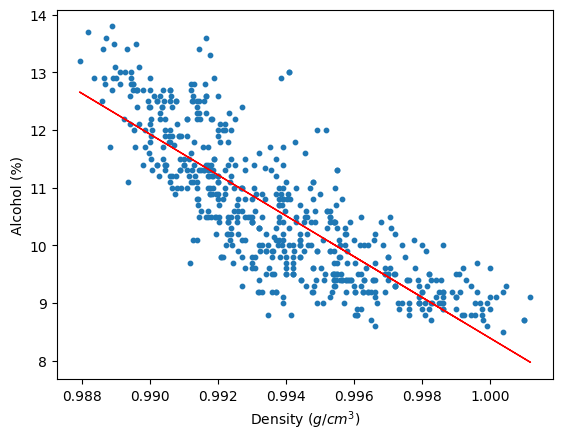

The regression line equation is given by y = -354 x + 362
Where R² = 0.6669739565392464


In [7]:
#This method does not split testing and training data
Q1 = wine['density'].quantile(0.25)
Q3 = wine['density'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = wine[(wine['density'] < Q1 - threshold * IQR) | (wine['density'] > Q3 + threshold * IQR)]
wine = wine.drop(outliers.index)
print(outliers)


x = np.array(wine['density']).reshape(-1, 1) #modifies data into numpy arrays
y = np.array(wine['alcohol']).reshape(-1, 1)
regr = LinearRegression()  #creates shorthand variable to call regression function
regr.fit(x,y)  #fits the regression line to data
y_predict = regr.predict(x)  #creates a variable based on models predicted y values
#plotting
plt.scatter(x, y, s = 10) 
plt.plot(x, y_predict, color="red", linewidth=1)
plt.xlabel('Density $(g/cm^{3})$')
plt.ylabel('Alcohol (%)')
plt.show()
#printing regression line data
print("The regression line equation is given by y =", int(regr.coef_), "x +", int(regr.intercept_))
print("Where R\u00b2 =", r2_score(y, y_predict))

### 1.2.2 Linear Regression with Train Test Split

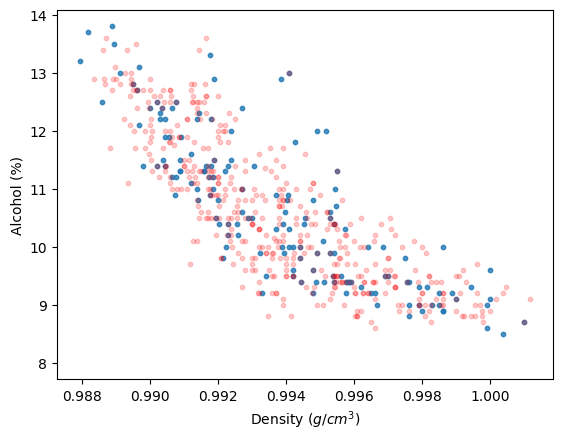

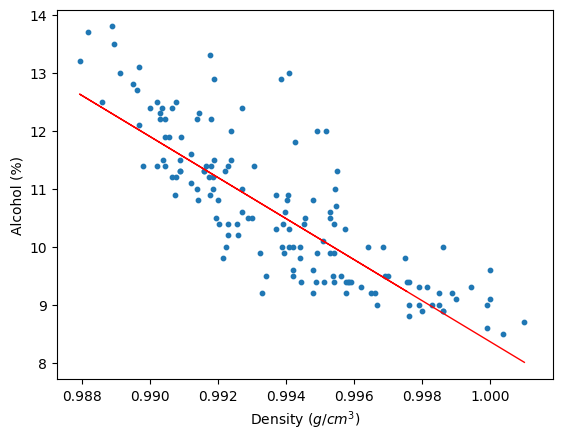

The regression line equation is given by y = -353 x + 362
Where R² = 0.6728928230697032


In [8]:
seed = 12345
#This method does split testing and training data
density = np.array(wine['density']).reshape(-1, 1) #modifies data into numpy arrays
alcohol = np.array(wine['alcohol']).reshape(-1, 1)
density_train, density_test, alcohol_train, alcohol_test = tts(density, alcohol, test_size = .25, random_state=seed) #splits test and training data
regr = LinearRegression()  #creates shorthand variable to call regression function
regr.fit(density_train, alcohol_train)  #fits the regression line to training data
alcohol_predict = regr.predict(density_test)  #predicts variable using test data
#plotting visualisation of test and training data split
plt.scatter(density_test, alcohol_test, alpha = 0.8, s = 10) #testing data in red
plt.scatter(density_train, alcohol_train, alpha = 0.2, s = 10, color='red')  #training data in blue
plt.xlabel('Density $(g/cm^{3})$')
plt.ylabel('Alcohol (%)')
plt.plot(density_test, alcohol_predict, color="red", linewidth=0) #invisible but ensures same plot area for report comparison
plt.show()
#plotting linear regression
plt.scatter(density_test, alcohol_test, s = 10)
plt.scatter(density_train, alcohol_train, alpha = 0) #invisible but ensures same plot area for report comparison
plt.plot(density_test, alcohol_predict, color="red", linewidth=1)
plt.xlabel('Density $(g/cm^{3})$')
plt.ylabel('Alcohol (%)')
plt.show()
#printing regression line data
print("The regression line equation is given by y =", int(regr.coef_), "x +", int(regr.intercept_))
print("Where R\u00b2 =", r2_score(alcohol_test, alcohol_predict))

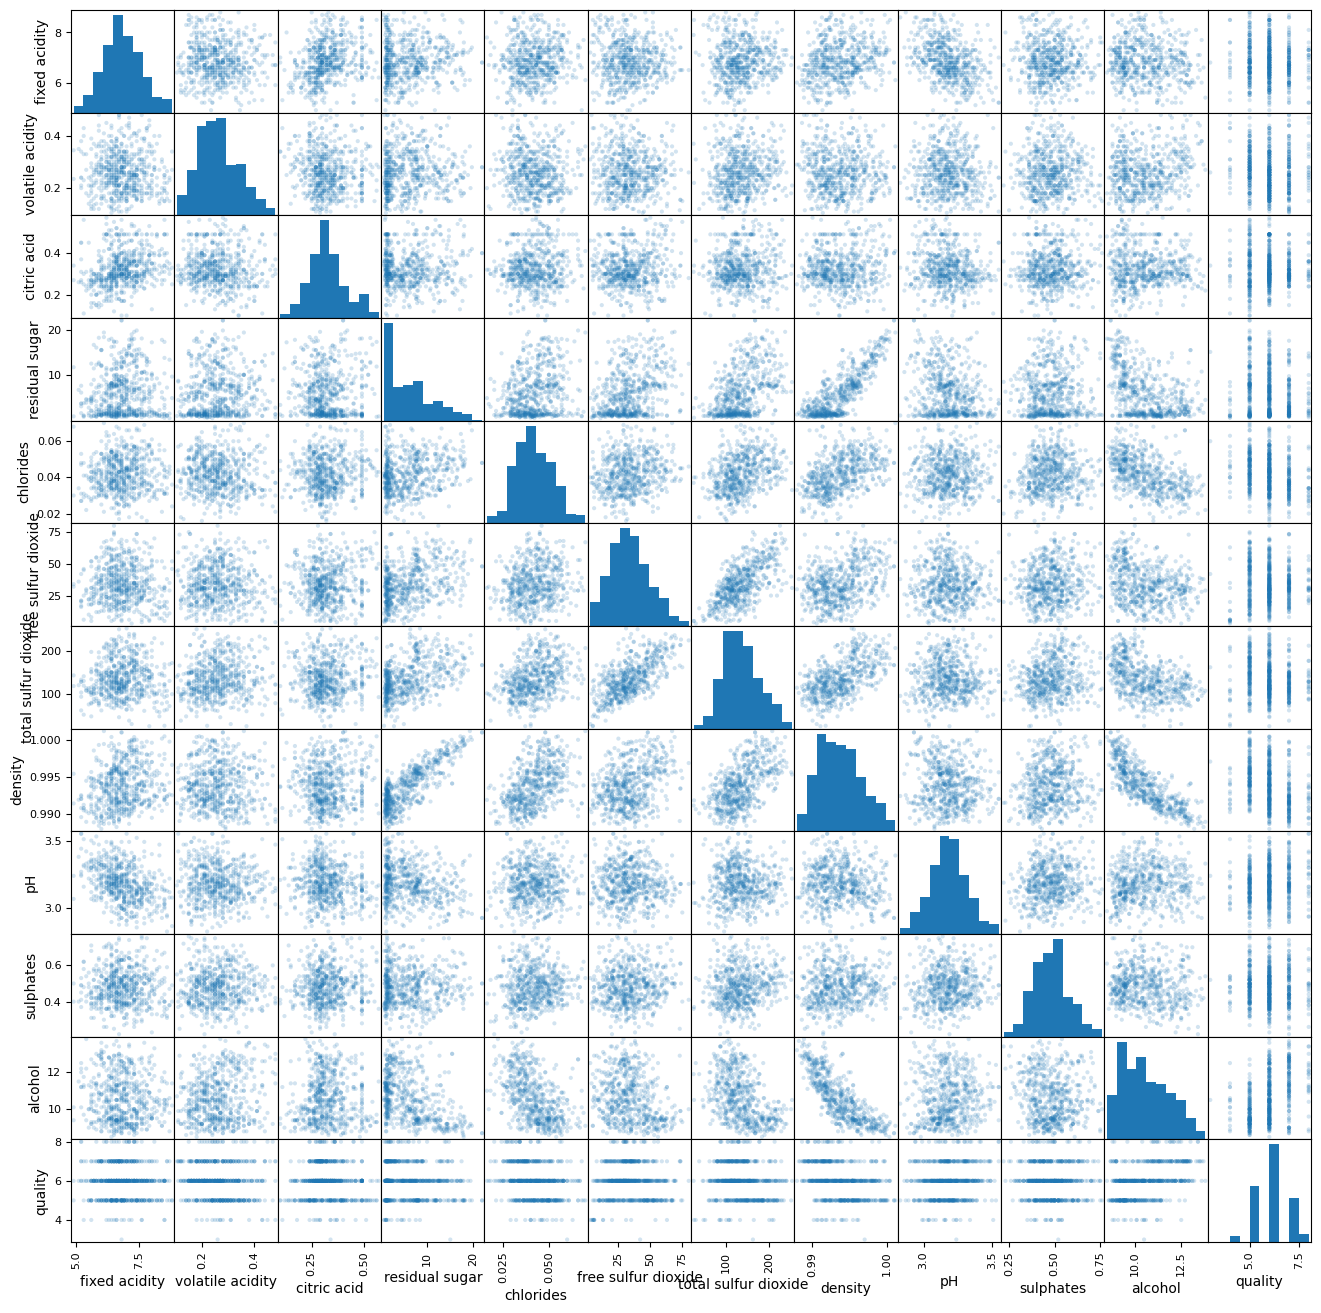

In [9]:
#for personal investigation/demonstrates loosely what variables may be related
scatter_matrix(wine,alpha=0.2,figsize=(16,16),diagonal='hist')
plt.show()

## Task 1.3


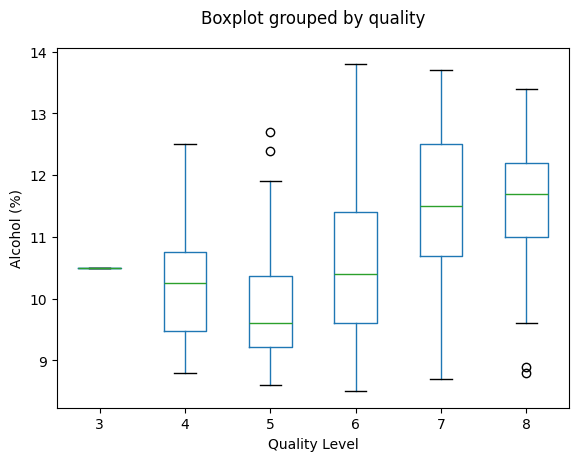

In [10]:
#not gonna bother annotating this very simple code
wine[['alcohol', 'quality']].boxplot(by='quality')
plt.grid(False)
plt.title("")
plt.xlabel('Quality Level')
plt.ylabel('Alcohol (%)')

plt.show()

# Task 2: Classification

## Task 2.1 

In [11]:
#knn modelling
k_value = 21  #choose kvalue
seed = 12345

#variable assigning and splitting
x_knn = wine.iloc[:, :-1].values  #defines knn attributes
y_knn = wine.iloc[:,  11].values  #defines knn labels
x_knn_train, x_knn_test, y_knn_train, y_knn_test = tts(x_knn, y_knn, test_size = .25, random_state=seed)  #splits data for training and testing
#normalising data
#ensures variables of larger or smaller magnitudes of some variables dont throw out knn model
x_knn_train = preprocessing.normalize(x_knn_train)  #normalises
x_knn_test = preprocessing.normalize(x_knn_test)
#knn modelling
classifier = KNeighborsClassifier(k_value, weights = 'distance')  #defining classifier and k value
classifier.fit(x_knn_train, y_knn_train)  #models knn to training data
classifier.get_params()  #displays in use knn parameters
y_knn_predict = classifier.predict(x_knn_test)  #defines models predicted label bases on attributes (quality by acidity,  etc..)


              precision    recall  f1-score   support

           4       0.00      0.00      0.00         3
           5       0.44      0.31      0.36        39
           6       0.45      0.75      0.57        65
           7       0.67      0.25      0.36        40
           8       0.00      0.00      0.00         3

    accuracy                           0.47       150
   macro avg       0.31      0.26      0.26       150
weighted avg       0.49      0.47      0.44       150

When k =  21
the accuracy is   47.333333333333336 %
the precision is  48.99382716049382 %
the f-score is    43.69872131721843 %


Text(0.5, 1.0, 'Normalized')

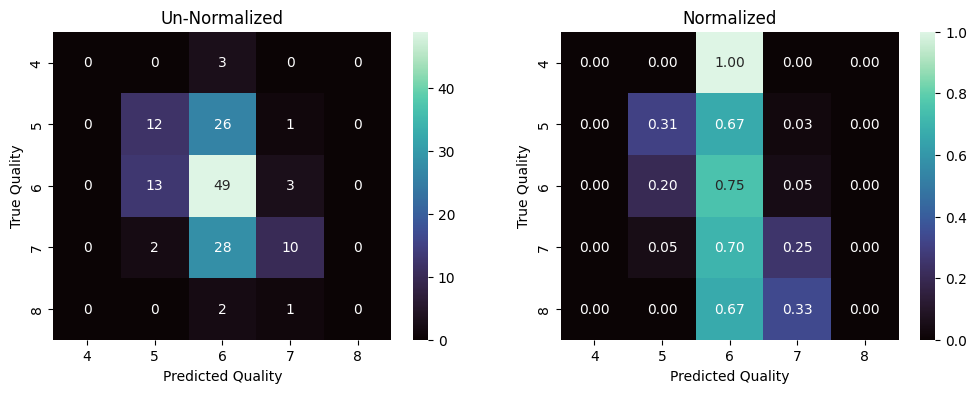

In [12]:
#knn analysis
print(classification_report(y_knn_test, y_knn_predict)) 
cm = metrics.confusion_matrix(y_knn_test, y_knn_predict)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#sns.heatmap(cmn, annot=True, cmap = 'mako',fmt='.2f', xticklabels=np.unique(y_knn_test), yticklabels=np.unique(y_knn_test))
#using weighted averages as some quality values have very few data points 
print("When k = ", k_value)
print("the accuracy is  ", metrics.accuracy_score(y_knn_test, y_knn_predict)*100, '%')  #accuracy
print("the precision is ", metrics.precision_score(y_knn_test,y_knn_predict, average='weighted')*100, '%') #precicion
print("the f-score is   ", metrics.f1_score(y_knn_test, y_knn_predict, average ='weighted')*100, '%')  #f score
#plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cmn, ax = axes[1], annot=True, cmap = 'mako',fmt='.2f', xticklabels=np.unique(y_knn_test), yticklabels=np.unique(y_knn_test))
sns.heatmap(cm, ax = axes[0], annot=True, cmap = 'mako', fmt='g', xticklabels=np.unique(y_knn_test), yticklabels=np.unique(y_knn_test))
axes[0].set_xlabel('Predicted Quality')
axes[0].set_ylabel('True Quality')
axes[1].set_xlabel('Predicted Quality')
axes[1].set_ylabel('True Quality')
axes[0].set_title('Un-Normalized')
axes[1].set_title('Normalized')


## Task 2.2 

### 2.2.1 Optimised Configurable Averaged Metric Tester

100%|██████████| 300/300 [05:22<00:00,  1.07s/it]


Text(0.09, 0.5, 'Percentage (%)')

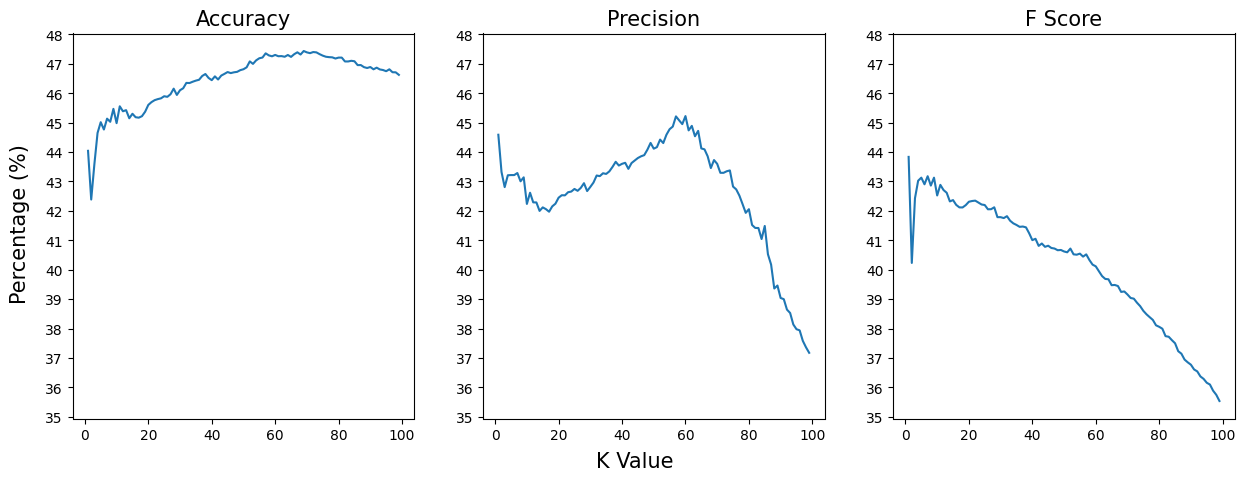

In [13]:
seed = 12345        #choose the random number gen seed
k_values = 100      #choose the max k value
sample_number = 300  #choose the number of samples for each k value

#initialize the seed
random.seed(seed)   
#variable assigning and splitting
x_knn = wine.iloc[:, :-1].values  #defines knn attributes
y_knn = wine.iloc[:,  11].values  #defines knn labels
k_range = range(1,k_values,1)  #sets the range of k values used

acc = []  #creates empty arrays for appending
prec = []
f = []
acc_avg = []  
prec_avg = []
f_avg = []

for i in tqdm(range(0, sample_number)):  
    acc.append([])  #scales the size of the arrays based on new loops
    prec.append([])
    f.append([])
    x_knn_train, x_knn_test, y_knn_train, y_knn_test = tts(x_knn, y_knn, test_size = .25, random_state = random.randint(0,1000))
    #normalising data
    #ensures variables of larger or smaller magnitudes of some variables dont throw out knn model
    x_knn_train = preprocessing.normalize(x_knn_train)  #normalises
    x_knn_test = preprocessing.normalize(x_knn_test)

    for k in k_range: #iteratively calculating the metrics for each k value
        classifier = KNeighborsClassifier(k)
        classifier.fit(x_knn_train, y_knn_train)
        y_knn_predict = classifier.predict(x_knn_test) 
        acc[i].append(metrics.accuracy_score(y_knn_test, y_knn_predict)*100)
        prec[i].append(metrics.precision_score(y_knn_test,y_knn_predict, average='weighted')*100)
        f[i].append(metrics.f1_score(y_knn_test, y_knn_predict, average ='weighted')*100)

acc = pd.DataFrame(acc) #making arrays data frames
prec = pd.DataFrame(prec)
f = pd.DataFrame(f)

acc_avg.append(acc.mean()) #calculating averages for each k value (each column)
prec_avg.append(prec.mean())
f_avg.append(f.mean())

acc_avg = np.transpose(acc_avg) #cant plot unless matrix is vertical
prec_avg = np.transpose(prec_avg)   
f_avg = np.transpose(f_avg)

#plotting
fig, axes = plt.subplots(1, 3, sharey='all', figsize=(15, 5))
axes[0].plot(k_range, acc_avg) 
axes[0].set_title("Accuracy", size = '15')
axes[1].plot(k_range, prec_avg)
axes[1].set_title("Precision", size = '15')
axes[1].tick_params(labelleft=True)
axes[2].plot(k_range, f_avg)
axes[2].set_title("F Score", size = '15')
axes[2].tick_params(labelleft=True)
plt.locator_params(axis='y', nbins=20) 
fig.text(0.5, 0.025, 'K Value', ha='center', va='center', size = '15')
fig.text(0.09, 0.5, 'Percentage (%)', ha='center', va='center', rotation='vertical', size = '15')

### 2.2.2 Un-optimised Configurable Averaged Metric Tester

100%|██████████| 99/99 [05:35<00:00,  3.39s/it]


Text(0.09, 0.5, 'Percentage (%)')

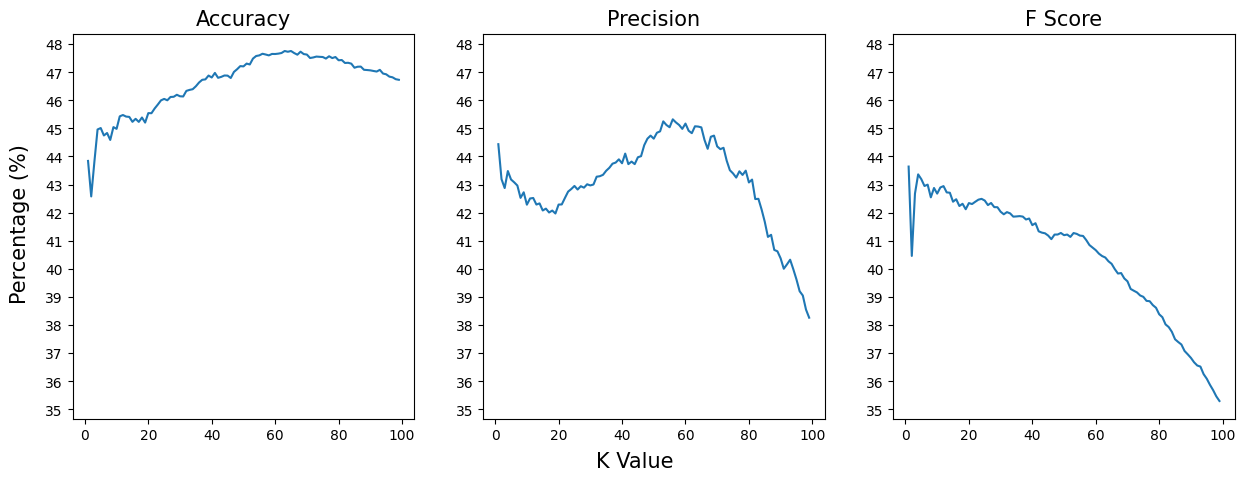

In [14]:
seed = 12345
k_values = 100
sample_values = 300


#data prep
random.seed(seed)
#variable assigning and splitting
x_knn = wine.iloc[:, :-1].values  #defines knn attributes
y_knn = wine.iloc[:,  11].values  #defines knn labels

seed_vals = [] 
for i in range(1,sample_values):  #generates a number of seeds according to sample_values from which to generate averaged metrics
    seed_vals.append(random.randint(0,10000))  #seed values between 1 and 1000, this is pretty arbitrary

k_range = range(1,k_values,1)

acc = []
prec = []
f = []

acc_avg = []
prec_avg = []
f_avg = []

for k in tqdm(k_range):
    for seed in seed_vals: 
        x_knn_train, x_knn_test, y_knn_train, y_knn_test = tts(x_knn, y_knn, test_size = .25, random_state = seed)
        #normalising data
        #ensures variables of larger or smaller magnitudes of some variables dont throw out knn model
        x_knn_train = preprocessing.normalize(x_knn_train)  #normalises
        x_knn_test = preprocessing.normalize(x_knn_test)

        classifier = KNeighborsClassifier(k)
        classifier.fit(x_knn_train, y_knn_train)
        y_knn_predict = classifier.predict(x_knn_test) 
        acc.append(metrics.accuracy_score(y_knn_test, y_knn_predict)*100)
        prec.append(metrics.precision_score(y_knn_test,y_knn_predict, average='weighted')*100)
        f.append(metrics.f1_score(y_knn_test, y_knn_predict, average ='weighted')*100)
    acc_avg.append(mean(acc))
    prec_avg.append(mean(prec))
    f_avg.append(mean(f))
    acc = []  #must clear arrays each k loop 
    prec = []
    f = []

#plotting  
fig, axes = plt.subplots(1, 3, sharey='all', figsize=(15, 5))
axes[0].plot(k_range, acc_avg) 
axes[0].set_title("Accuracy", size = '15')
axes[1].plot(k_range, prec_avg)
axes[1].set_title("Precision", size = '15')
axes[1].tick_params(labelleft=True)
axes[2].plot(k_range, f_avg)
axes[2].set_title("F Score", size = '15')
axes[2].tick_params(labelleft=True)
plt.locator_params(axis='y', nbins=20) 
fig.text(0.5, 0.025, 'K Value', ha='center', va='center', size = '15')
fig.text(0.09, 0.5, 'Percentage (%)', ha='center', va='center', rotation='vertical', size = '15')

### 2.2.3 Single Sample Metric Tester

Text(0.09, 0.5, 'Percentage (%)')

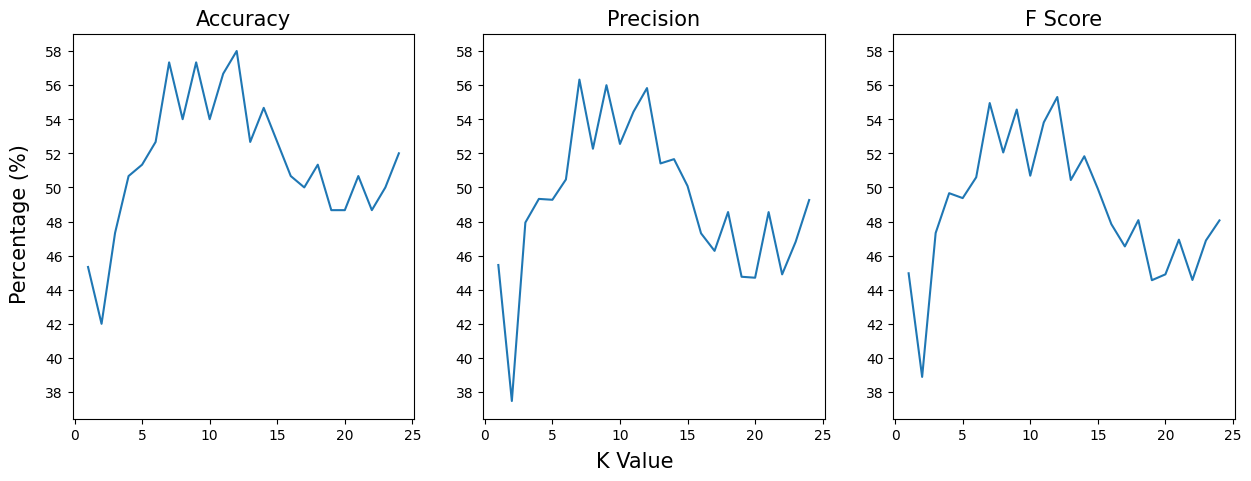

In [15]:
#data prep
#variable assigning and splitting
x_knn = wine.iloc[:, :-1].values  #defines knn attributes
y_knn = wine.iloc[:,  11].values  #defines knn labels
x_knn_train, x_knn_test, y_knn_train, y_knn_test = tts(x_knn, y_knn, test_size = .25)  #splits data for training and testing
#normalising data
#ensures variables of larger or smaller magnitudes of some variables dont throw out knn model

x_knn_train = preprocessing.normalize(x_knn_train)  #normalises
x_knn_test = preprocessing.normalize(x_knn_test)

k_range = range(1,25)
acc_scores = []
prec_scores = []
f_scores = []

for k in k_range:
    classifier = KNeighborsClassifier(k)
    classifier.fit(x_knn_train, y_knn_train)
    y_knn_predict = classifier.predict(x_knn_test)
    acc_scores.append(metrics.accuracy_score(y_knn_test, y_knn_predict)*100)
    prec_scores.append(metrics.precision_score(y_knn_test,y_knn_predict, average='weighted')*100)
    f_scores.append(metrics.f1_score(y_knn_test, y_knn_predict, average ='weighted')*100)

#plottinh
fig, axes = plt.subplots(1, 3, sharey='all', figsize=(15, 5))
axes[0].plot(k_range, acc_scores) 
axes[0].set_title("Accuracy", size = '15')
axes[1].plot(k_range, prec_scores)
axes[1].set_title("Precision", size = '15')
axes[1].tick_params(labelleft=True)
axes[2].plot(k_range, f_scores)
axes[2].set_title("F Score", size = '15')
axes[2].tick_params(labelleft=True)
plt.locator_params(axis='y', nbins=20) 
fig.text(0.5, 0.025, 'K Value', ha='center', va='center', size = '15')
fig.text(0.09, 0.5, 'Percentage (%)', ha='center', va='center', rotation='vertical', size = '15')

## Task 2.3 

100%|██████████| 7/7 [00:31<00:00,  4.52s/it]


Text(0.09, 0.5, 'Percentage (%)')

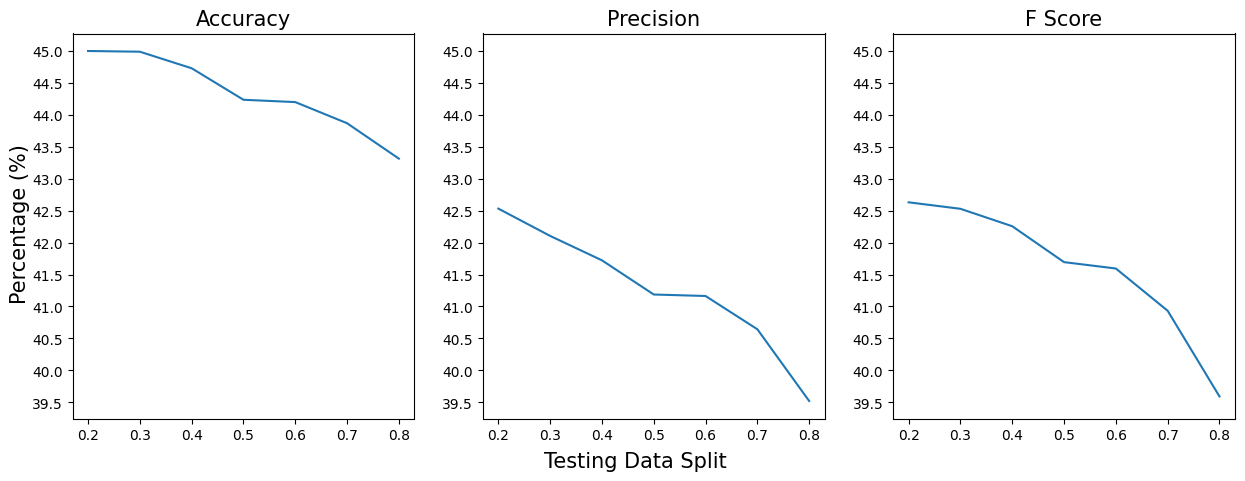

In [16]:
seed = 12345
k_value = 10
sample_values = 300
test_splits = [.2, .3, .4, .5, .6, .7, .8]

#data prep
random.seed(seed)
#variable assigning and splitting
x_knn = wine.iloc[:, :-1].values  #defines knn attributes
y_knn = wine.iloc[:,  11].values  #defines knn labels

#
seed_vals = []
for i in range(1,sample_values): #generates a number of seeds according to sample_values from which to generate averaged metrics
    seed_vals.append(random.randint(0,1000)) #seed values between 1 and 1000, this is pretty arbitrary

acc = []
prec = []
f = []

acc_avg = []
prec_avg = []
f_avg = []

for t in tqdm(test_splits):  #using a range of test splits to itteratively calculate metrics
    for seed in seed_vals:  #related to sample number used to average
        x_knn_train, x_knn_test, y_knn_train, y_knn_test = tts(x_knn, y_knn, test_size = t, random_state = seed)
        #normalising data
        #ensures variables of larger or smaller magnitudes of some variables dont throw out knn model
        x_knn_train = preprocessing.normalize(x_knn_train)  #normalises
        x_knn_test = preprocessing.normalize(x_knn_test)

        classifier = KNeighborsClassifier(k_value)
        classifier.fit(x_knn_train, y_knn_train)
        y_knn_predict = classifier.predict(x_knn_test) 
        acc.append(metrics.accuracy_score(y_knn_test, y_knn_predict)*100)
        prec.append(metrics.precision_score(y_knn_test,y_knn_predict, average='weighted')*100)
        f.append(metrics.f1_score(y_knn_test, y_knn_predict, average ='weighted')*100)
    acc_avg.append(mean(acc))
    prec_avg.append(mean(prec))
    f_avg.append(mean(f))
    acc = []  #must clear arrays each k loop 
    prec = []
    f = []

#plotting  
fig, axes = plt.subplots(1, 3, sharey='all', figsize=(15, 5))
axes[0].plot(test_splits, acc_avg) 
axes[0].set_title("Accuracy", size = '15')
axes[1].plot(test_splits, prec_avg)
axes[1].set_title("Precision", size = '15')
axes[1].tick_params(labelleft=True)
axes[2].plot(test_splits, f_avg)
axes[2].set_title("F Score", size = '15')
axes[2].tick_params(labelleft=True)
plt.locator_params(axis='y', nbins=20) 
fig.text(0.5, 0.025, 'Testing Data Split', ha='center', va='center', size = '15')
fig.text(0.09, 0.5, 'Percentage (%)', ha='center', va='center', rotation='vertical', size = '15')

# Task 3: Clustering

## Task 3.1 and 3.3

cluster,0,1,2,3,4,5
target,,,,,,
3.0,1.0,0.0,0.0,0.0,0.0,0.0
4.0,3.0,2.0,2.0,6.0,1.0,2.0
5.0,60.0,1.0,16.0,22.0,12.0,47.0
6.0,66.0,5.0,55.0,43.0,35.0,71.0
7.0,22.0,1.0,38.0,11.0,20.0,33.0
8.0,7.0,0.0,4.0,1.0,5.0,6.0


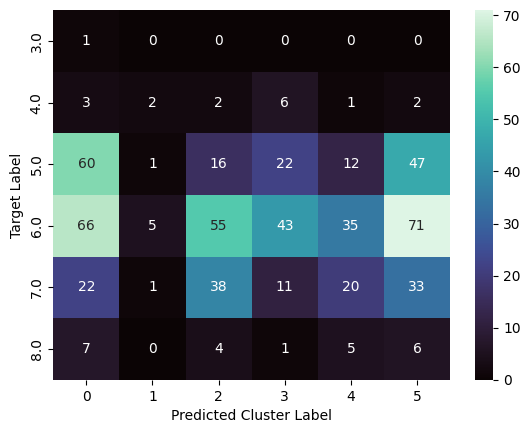

In [17]:
cluster_num = 6 #choose the cluster number
seed = 1234567


x_raw = pd.DataFrame(wine.iloc[:, :-1])  #isolates all data except our target prediction (quality)
x = preprocessing.normalize(x_raw)
x = pd.DataFrame(x, columns = x_raw.columns)
model = cluster.KMeans(n_clusters=cluster_num, random_state=seed)
results = model.fit(x)
#Task 3.1 above
#seperating the code breaks it so im using the same cell block 
#Task 3.2 below
x['cluster'] = results.predict(x)
x['target'] = wine.quality
x['count'] = 'c'
k_data = x[['cluster', 'target', 'count']].groupby(['cluster', 'target']).agg('count')
k_data = k_data.reset_index() #this fixes the data frame being only one column  
confusion_matrix = k_data.pivot(index='target', columns='cluster', values='count') #i spent 3 hours trying to do what this function does :L
confusion_matrix = confusion_matrix.fillna(0)
display(confusion_matrix)  #same info as in the heatmap
sns.heatmap(confusion_matrix, annot=True, cmap = 'mako', fmt='g')  #heatmap functions as a visual confusion matrix
plt.ylabel('Target Label')
plt.xlabel('Predicted Cluster Label')
plt.show()

## Task 3.2 

100%|██████████| 19/19 [00:02<00:00,  8.60it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

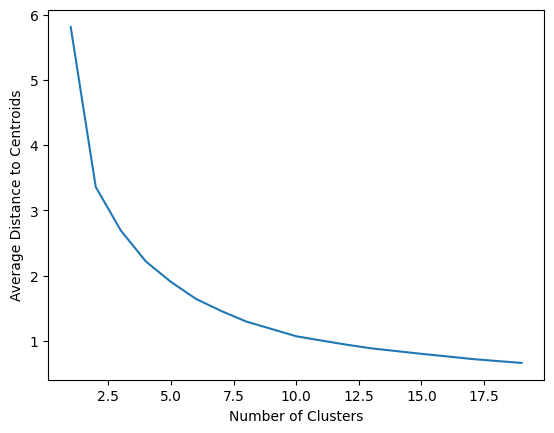

In [19]:

cluster_num = 20
x = wine.iloc[:, :-1].values
#normalising data
#ensures variables of larger or smaller magnitudes of some variables dont throw out knn model
x_norm = preprocessing.normalize(x)  #computes the scaling parameters for data


elbow = []
for i in tqdm(range(1, cluster_num)):
    kmeans = KMeans(n_clusters= i, init = 'k-means++', max_iter = 300, n_init = 25)
    kmeans.fit(x_norm)
    elbow.append(kmeans.inertia_)

plt.plot(range(1, cluster_num), elbow)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance to Centroids')
plt.show